# Rank models

### Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import scanpy as sc
import sklearn
from scipy.stats import ttest_ind
import itertools as it
import scipy
import scipy.cluster.hierarchy as sch
import pickle

In [2]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing as pp

In [3]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

### generate_seeds_samples

This function generates a dictionary with the seeds that will be used troughout the classification. It is important to set the seeds as a means for reproducibility of the classification. Use this function if you want to set new seeds. In this notebook we will be using pre-computed seeds in our analysis.

The dictionary keys are "n" seeds which is the number of iterations of the models. The default n is 100.
The values are the list of indexes of the dataset containing the class 1 that are selected at each cycle.

- n
- sample_size (the size of the list generated)
- max_index (the maximum index that can be selected from the data)

Bellow we have the seeds used in the comparison between classificators.

In [5]:
def generate_seeds_samples(n, sample_size, max_index):
    seeds = np.random.randint(1000, size=n)
    dic_seeds = {}
    for seed in seeds:
        dic_seeds[seed] = np.random.randint(max_index, size=sample_size)
    return dic_seeds

In [6]:
seeds = pd.read_pickle(r"./data/gene_lists/df_seeds.pkl")
seeds.shape
#set of seeds used during the pre-computed ranking of the features lists. You may use it or not

(24, 98)

### Split dataset into class0 and class1

This function separates the adata object in two containing the elements from the two classes.
- adata
- classes (a dictionary containing in the keys 'class_0' and 'class_1'. In the values another dictionary with the key as column name and the value as the value the column assumes according to each class)

The function returns separate dataframes for each class

In [7]:
#In this case we want class_0 to be defined as the cells where in column 'Extra' we have the 'D' values
#while the class_1, the cells where in column 'labels' we have '1.0' values.
def split_classes(adata, classes={'class_0':{'Extra':'D'}, 'class_1':{'labels':1.0}}):
    target1 = list(classes['class_0'].keys())[0]
    target2 = list(classes['class_1'].keys())[0]
    print(target1)
    df_class_0 = adata[(adata.obs[target1]==classes['class_0'][target1]),:].obs
    df_class_1 = adata[(adata.obs[target2]==classes['class_1'][target2]),:].obs
    return df_class_0, df_class_1

### do_logreg_n4

The goal is to perform the model "n" times and average all the results as a means of statistical confirmation.
The dataset has to be previously divided between class0 (dead) and class1 (alive)
- df_class0
- df_class1
- target (the target feature, ideally a binary categorical)
- seeds (obligatory for the reproducebility)
- n (number of iterations)
- max_degree (maximun polynomial degree to be tested with k-fold cross validation)
- sampling_strategy (to overcome the imbalancing problem). Can be 'under' for undersampling the majority class, 'over' for oversampling the minority class or 'SMOTE' for the SMOTE synthetic algorithm.

In [34]:
def do_logreg_n4(df_class0, df_class1, target, features, seeds, max_degree=2, max_knn=2,
                 model_type="logistic",
                 sampling_strategy='SMOTE'):

    #setting-up the listts to contain the results for each run
    f1_train = []
    f1_test = []
    diff_f1 = []
    acc_train = []
    acc_test = []
    diff_acc = []
    pre_train = []
    pre_test = []
    diff_pre = []
    rec_train = []
    rec_test = []
    diff_rec = []
    cnf_mtx_test = []
    deg = []
    knn=[]

    #setting-up split test size
    split_test_size = 0.3
    
    #how many degrees will be tested in the the Polynomial regression
    degrees = list(range(1, max_degree+1))
    neighbors=list(range(1,max_knn))
    #creating the f1 scorer
    f1_scorer = make_scorer(f1_score, greater_is_better=True)
    

    #creo l'intero dsataset
    data = pd.concat([df_class0, df_class1])
    y = data[target].to_numpy().astype(np.float32)
    if len(features) == 1:
        X = data[features].to_numpy().astype(np.float32).reshape(-1,1)
    else:
        X = data[features].to_numpy().astype(np.float32)

    for seed in seeds:
        #creating train and test sets

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size, 
                                                        random_state=int(seed), stratify=y)
        #checking the sampling strategies

        if sampling_strategy == 'under':
            ros = RandomOverSampler(sampling_strategy='minority',random_state=seed)
            X_train, y_train = ros.fit_resample(X_train, y_train)
        elif sampling_strategy == 'over':
            rus=RandomUnderSampler(sampling_strategy='majority',random_state=seed)
            X_train, y_train = rus.fit_resample(X_train, y_train)
        elif sampling_strategy == 'SMOTE':
            simple_SMOTE = SMOTE(sampling_strategy='minority', random_state=seed)
            X_train, y_train = simple_SMOTE.fit_resample(X_train, y_train)
            
        else:
            print('sampling strategy not recognized. Using imbalanced classes (not recommended)')


        #setting-up cross validation
        cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)

        if model_type=="logistic":
            #testo solo il grado
            val_scores = np.zeros(len(degrees))
            # Validation for the selection of the degree hyperparameter
            for i, d in enumerate(degrees):
                
                model = Pipeline([('poly', PolynomialFeatures(degree=d, include_bias=False)),
                                ('scale', StandardScaler()),
                                ('logistic', LogisticRegression(fit_intercept=True))])       
                #cross-validation scores based on f1 score
                scores = cross_val_score(model, X_train, y_train, scoring=f1_scorer, cv=cv)
                #aggregation into a mean and addition to the list
            val_scores[i] = np.mean(scores)

            # Identifies which is the best degree
            best_model_idx = np.argmax(val_scores)
            best_degree = degrees[best_model_idx]

            # Train again the Pipeline using the best parameter and the whole training set
            model = Pipeline([('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
                            ('scale', StandardScaler()),
                            ('logistic', LogisticRegression(fit_intercept=True))])
        else:
            #testo solo il numero dei vicini
            val_scores = np.zeros(len(neighbors))
            # Validation for the selection of the degree hyperparameter
            for i, d in enumerate(neighbors):
                
                model = Pipeline([
                                ('scale', StandardScaler()),
                                ('knn', KNeighborsClassifier(n_neighbors=d))
                                ])       
                #cross-validation scores based on f1 score
                scores = cross_val_score(model, X_train, y_train, scoring=f1_scorer, cv=cv)
                #aggregation into a mean and addition to the list
            val_scores[i] = np.mean(scores)

            # Identifies which is the best degree
            best_model_idx = np.argmax(val_scores)
            best_knn = neighbors[best_model_idx]

        
            # Train again the Pipeline using the best parameter and the whole training set
            model = Pipeline([
                            ('scale', StandardScaler()),
                            ('knn', KNeighborsClassifier(n_neighbors=best_knn))
                            ])

        model = model.fit(X_train, y_train)
        y_predict_train = model.predict(X_train)
        y_predict_test = model.predict(X_test)

        #computing all the metrics and adding them to their respective lists
        f1tr = f1_score(y_train, y_predict_train,average="binary")
        f1te = f1_score(y_test, y_predict_test,average="binary")
        f1_train.append(f1tr)
        f1_test.append(f1te)
        diff_f1.append(f1tr - f1te)
        
        acctr = accuracy_score(y_train, y_predict_train)
        accte = accuracy_score(y_test, y_predict_test)
        acc_train.append(acctr)
        acc_test.append(accte)
        diff_acc.append(acctr - accte)
        
        pretr = precision_score(y_train, y_predict_train)
        prete = precision_score(y_test, y_predict_test)
        pre_train.append(pretr)
        pre_test.append(prete)
        diff_pre.append(pretr - prete)
        
        rectr = recall_score(y_train, y_predict_train)
        recte = recall_score(y_test, y_predict_test)
        rec_train.append(rectr)
        rec_test.append(recte)
        diff_rec.append(rectr - recte)
        
        cnf_mtx_test.append(confusion_matrix(y_test, y_predict_test))
        if model_type=="logistic":
            deg.append(best_degree)
        else:
            deg.append(best_knn)
    #aggregating metrics into mean of the runs
    mean_f1_train = np.mean(f1_train)
    std_f1_train = np.std(f1_train)
    mean_f1_test = np.mean(f1_test)
    std_f1_test = np.std(f1_test)
    mean_diff_f1 = np.mean(diff_f1)
    std_diff_f1 = np.std(diff_f1)
    
    mean_acc_train = np.mean(acc_train)
    std_acc_train = np.std(acc_train)
    mean_acc_test = np.mean(acc_test)
    std_acc_test = np.std(acc_test)
    mean_diff_acc = np.mean(diff_acc)
    std_diff_acc = np.std(diff_acc)
    
    mean_pre_train = np.mean(pre_train)
    std_pre_train = np.std(pre_train)
    mean_pre_test = np.mean(pre_test)
    std_pre_test = np.std(pre_test)
    mean_diff_pre = np.mean(diff_pre)
    std_diff_pre = np.std(diff_pre) 
    
    mean_rec_train = np.mean(rec_train)
    std_rec_train = np.std(rec_train)
    mean_rec_test = np.mean(rec_test)
    std_rec_test = np.std(rec_test)
    mean_diff_rec = np.mean(diff_rec)
    std_diff_rec = np.std(diff_rec)
    
    mean_cnf_matrix_test = np.mean(cnf_mtx_test, axis = 0)
    mean_degrees = np.mean(deg)
    
    #20 arguments returned
    return mean_f1_train, std_f1_train, mean_f1_test, std_f1_test, mean_diff_f1, std_diff_f1, mean_acc_train, std_acc_train, mean_acc_test, std_acc_test, mean_diff_acc, std_diff_acc, mean_pre_train, std_pre_train, mean_pre_test, std_pre_test, mean_diff_pre, std_diff_pre, mean_rec_train, std_rec_train, mean_rec_test, std_rec_test, mean_diff_rec, std_diff_rec, mean_cnf_matrix_test, mean_degrees

### logreg_combinatorial4

This function works like the "do_logreg_n4" but it sets up a combinatorial permutation of all the possible combinations of features from 1 to m elements, with m being the number of features passed. 
For example for three features: [feat1, feat2, feat3]
the feature lists generated will be:
[feat1]; [feat2]; [feat3]; [feat1, feat2]; [feat1, feat3]; [feat2, feat3]; [feat1, feat2, feat3]

The model is then performed n times on each list of features using the previous function do_logreg_n4. In the end it returns a dataframe of the lists ranked by accuracy of the classificator.
Warning: this function takes a long time to run for long lists of features.

In [9]:
def logreg_combinatorial4(dataset1, dataset2, 
                          target, 
                          features, 
                          seeds,
                          model_type="logistic",
                          sampling_strategy='SMOTE'):
    
    #setting-up the list of features lists
    features_combinations = []
    number = int(len(features))
    
    for i in range(0, number+1):
        #generating the lists of features
        [features_combinations.append(list(x)) for x in it.combinations(features, i)]

    #df columns
    features_combinations.pop(0) #removing first element because empty
    features_index = []

    #setting-up lists of metrics
    mean_f1_train = []
    std_f1_train = []
    mean_f1_test = []
    std_f1_test = []
    mean_diff_f1 = []
    std_diff_f1 = []
    
    mean_acc_train = []
    std_acc_train = []
    mean_acc_test = []
    std_acc_test = []
    mean_diff_acc = []
    std_diff_acc = []
    
    mean_pre_train = []
    std_pre_train = []
    mean_pre_test = []
    std_pre_test = []
    mean_diff_pre = []
    std_diff_pre = []
    
    mean_rec_train = []
    std_rec_train = []
    mean_rec_test = []
    std_rec_test = []
    mean_diff_rec = []
    std_diff_rec = []
    
    mean_cnf_mtx_test = []
    code = []
    mean_degrees = []
    
    print('number of features: {x}'.format(x=number))
    print('number of lists: {x}'.format(x=len(features_combinations)))
    print('number of iterations to be performed for each list: {x}'.format(x=len(seeds)))
    
    for features in features_combinations:
        print(features)
        features_index.append('list_{x}'.format(x=features_combinations.index(features)))
        #mean_f1_train, std_f1_train, mean_f1_test, std_f1_test, mean_diff_f1, std_diff_f1, mean_acc_train, std_acc_train, mean_acc_test, std_acc_test, mean_diff_acc, std_diff_acc, mean_pre_train, std_pre_train, mean_pre_test, std_pre_test, mean_diff_pre, std_diff_pre, mean_rec_train, std_rec_train, mean_rec_test, std_rec_test, mean_diff_rec, std_diff_rec, mean_cnf_matrix_test, mean_coeffs
        #do_logreg_n4 returns a lot of values
        #each time the model is trained and tested with a different list of features
        resuls= do_logreg_n4(dataset1, dataset2, target, features, seeds=seeds, model_type=model_type,sampling_strategy=sampling_strategy)
        [f1tr, stdf1tr, f1te, stdf1te, difff1, stddifff1, acctr, stdacctr, accte, stdaccte, diffacc, stddiffacc, pretr, stdpretr, prete, stdprete, diffpre, stddiffpre, rectr, stdrectr, recte, stdrecte, diffrec, stddiffrec, cnf_mtx, degree ]= resuls
        
        mean_f1_train.append(f1tr)
        std_f1_train.append(stdf1tr)
        mean_f1_test.append(f1te)
        std_f1_test.append(stdf1te)
        mean_diff_f1.append(difff1)
        std_diff_f1.append(stddifff1)
        
        mean_acc_train.append(acctr)
        std_acc_train.append(stdacctr)
        mean_acc_test.append(accte)
        std_acc_test.append(stdaccte)
        mean_diff_acc.append(diffacc)
        std_diff_acc.append(stddiffacc)
        
        mean_pre_train.append(pretr)
        std_pre_train.append(stdpretr)
        mean_pre_test.append(prete)
        std_pre_test.append(stdprete)
        mean_diff_pre.append(diffpre)
        std_diff_pre.append(stddiffpre)
        
        mean_rec_train.append(rectr)
        std_rec_train.append(stdrectr)
        mean_rec_test.append(recte)
        std_rec_test.append(stdrecte)
        mean_diff_rec.append(diffrec)
        std_diff_rec.append(stddiffrec)
        
        mean_cnf_mtx_test.append(cnf_mtx)
        code.append(features)
        mean_degrees.append(degree)
        print('{x}/{tot}'.format(x=features_combinations.index(features)+1, tot=len(features_combinations)))

    #transforming the results into a dataframe
    features_df = pd.DataFrame(index=features_index, columns=['mean_f1_train', 'std_f1_train', 'mean_f1_test', 'std_f1_test',
                                                              'mean_diff_f1', 'std_diff_f1', 
                                                              'mean_acc_train', 'std_acc_train', 'mean_acc_test', 'std_acc_test',
                                                              'mean_diff_acc', 'std_diff_acc', 'mean_pre_train', 'std_pre_train',
                                                              'mean_pre_test', 'std_pre_test', 'mean_diff_pre', 'std_diff_pre',
                                                              'mean_rec_train', 'std_rec_train', 'mean_rec_test', 'std_rec_test',
                                                              'mean_diff_rec', 'std_diff_rec',
                                                             'mean_cnf_mtx_test', 'mean_degrees','code', 
                                                              'rank'])
    features_df['mean_f1_train'] = mean_f1_train
    features_df['std_f1_train'] = std_f1_train
    features_df['mean_f1_test'] = mean_f1_test
    features_df['std_f1_test'] = std_f1_test
    features_df['mean_diff_f1'] = mean_diff_f1
    features_df['std_diff_f1'] = std_diff_f1
    
    features_df['mean_acc_train'] = mean_acc_train
    features_df['std_acc_train'] = std_acc_train
    features_df['mean_acc_test'] = mean_acc_test
    features_df['std_acc_test'] = std_acc_test
    features_df['mean_diff_acc'] = mean_diff_acc
    features_df['std_diff_acc'] = std_diff_acc
    
    features_df['mean_pre_train'] = mean_pre_train
    features_df['std_pre_train'] = std_pre_train
    features_df['mean_pre_test'] = mean_pre_test
    features_df['std_pre_test'] = std_pre_test
    features_df['mean_diff_pre'] = mean_diff_pre
    features_df['std_diff_pre'] = std_diff_pre
    
    features_df['mean_rec_train'] = mean_rec_train
    features_df['std_rec_train'] = std_rec_train
    features_df['mean_rec_test'] = mean_rec_test
    features_df['std_rec_test'] = std_rec_test
    features_df['mean_diff_rec'] = mean_diff_rec
    features_df['std_diff_rec'] = std_diff_rec
    
    features_df['mean_cnf_mtx_test'] = mean_cnf_mtx_test
    features_df['code'] = code
    features_df['mean_degrees'] = mean_degrees
    #sorting values based onn mean f1 score in the test set
    features_df.sort_values(by=['mean_f1_test'], ascending = False, inplace=True)
    
    for feature in features:
        features_df[feature] = 0
    
    for index in features_df.index:
        for feature in features_df.loc[index,'code']:
            features_df.loc[index,feature] = 1

    #creating a rank
    features_df['rank'] = np.linspace(start=1, stop=features_df.shape[0], num=features_df.shape[0])
    features_df.set_index('rank', drop=False, inplace=True)
    
    return features_df

In [10]:
adata_mouse_3_pp = sc.read_h5ad(r"./outputs/adata_mouse_3_pp.pkl")

### Model ranking

In [94]:
#splitting dataframe into dead and alive cells
dead, alive = split_classes(adata_mouse_3_pp)
dead

Extra


,labels,Extra,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_apex_only,pct_counts_apex_only,total_counts_frac_seq_only,pct_counts_frac_seq_only,total_counts_lncrna,pct_counts_lncrna,total_counts_in_common_apex_frac_seq,pct_counts_in_common_apex_frac_seq,total_counts_control_agg,pct_counts_control_agg
2i_3_55,0.0,D,8708,8700,792644.68750,189997.312500,23.970049,105398.281250,13.297039,83.802460,0.010573,537.119629,0.067763,27.634245,0.003486,47.250729,0.005961,24468.230469,3.086911
2i_3_74,0.0,D,8685,8684,743908.68750,382920.593750,51.474144,50091.273438,6.733525,162.016312,0.021779,612.440308,0.082327,4.240090,0.000570,1.736489,0.000233,22577.589844,3.034994
2i_3_75,0.0,D,9927,9925,744331.87500,330827.375000,44.446217,65233.710938,8.764063,186.372559,0.025039,441.818756,0.059358,4.008549,0.000539,16.335190,0.002195,22546.660156,3.029114
2i_3_81,0.0,D,6861,6860,776147.25000,264396.812500,34.065292,66048.601562,8.509803,293.842346,0.037859,367.483826,0.047347,0.000000,0.000000,84.941345,0.010944,23560.894531,3.035622
2i_3_93,0.0,D,8990,8987,711284.75000,375009.125000,52.722782,40869.398438,5.745856,112.814774,0.015861,382.169586,0.053729,4.197289,0.000590,3.735358,0.000525,21566.332031,3.032025
a2i_3_5,0.0,D,5860,5858,749046.62500,711002.875000,94.921043,4764.084961,0.636020,4.287537,0.000572,4.739263,0.000633,1.124792,0.000150,0.000000,0.000000,25075.009766,3.347589
a2i_3_32,0.0,D,8124,8124,746048.87500,602355.625000,80.739433,29408.515625,3.941902,62.311474,0.008352,83.760109,0.011227,2.666718,0.000357,1.417979,0.000190,23803.949219,3.190669
a2i_3_46,0.0,D,8263,8263,804032.50000,252442.484375,31.397051,114524.617188,14.243780,80.988571,0.010073,410.440674,0.051048,3.643741,0.000453,32.947151,0.004098,24331.027344,3.026125
a2i_3_55,0.0,D,8306,8305,828516.56250,203855.140625,24.604836,123159.734375,14.865090,171.696579,0.020723,693.507385,0.083705,0.351162,0.000042,0.000000,0.000000,25515.185547,3.079623
a2i_3_63,0.0,D,7884,7881,843804.31250,157987.687500,18.723261,123146.875000,14.594247,526.306519,0.062373,359.781311,0.042638,2.239357,0.000265,0.728967,0.000086,25703.755859,3.046175


In [93]:
alive

,labels,Extra,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_apex_only,pct_counts_apex_only,total_counts_frac_seq_only,pct_counts_frac_seq_only,total_counts_lncrna,pct_counts_lncrna,total_counts_in_common_apex_frac_seq,pct_counts_in_common_apex_frac_seq,total_counts_control_agg,pct_counts_control_agg
2i_3_1,1.0,G,7343,7342,751806.1875,344606.500000,45.837147,76945.210938,10.234714,71.897903,0.009563,324.269226,0.043132,0.686075,0.000091,48.745010,0.006484,23582.796875,3.136819
2i_3_2,1.0,G,8198,8197,828963.0625,119525.609375,14.418690,138415.640625,16.697445,510.377960,0.061568,676.499695,0.081608,111.282761,0.013424,0.288049,0.000035,25309.443359,3.053144
2i_3_4,1.0,G,7879,7878,836599.5000,129189.671875,15.442236,130173.429688,15.559827,89.635078,0.010714,390.982147,0.046735,21.949064,0.002624,25.886753,0.003094,25964.273438,3.103549
2i_3_5,1.0,G,8057,8057,865648.9375,58412.328125,6.747808,123120.632812,14.222929,438.315155,0.050634,607.157227,0.070139,0.000000,0.000000,5.335428,0.000616,26313.613281,3.039756
2i_3_6,1.0,G,8742,8741,843173.7500,97892.023438,11.609947,139215.859375,16.510933,153.715912,0.018231,363.107330,0.043064,1.287474,0.000153,7.993662,0.000948,25298.707031,3.000414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2i_5_90,1.0,G,8112,8111,861520.5000,79435.890625,9.220429,115582.406250,13.416095,125.629311,0.014582,489.145630,0.056777,0.000000,0.000000,37.673828,0.004373,25971.064453,3.014561
2i_5_92,1.0,G,8205,8202,848197.7500,146478.890625,17.269426,103697.273438,12.225601,413.465729,0.048746,769.047485,0.090668,25.306046,0.002984,2.620146,0.000309,25564.757812,3.014009
2i_5_94,1.0,G,8608,8607,864421.0000,88516.359375,10.239960,125820.531250,14.555470,107.637352,0.012452,360.102844,0.041658,0.000000,0.000000,2.234550,0.000259,25874.119141,2.993232
2i_5_95,1.0,G,7509,7507,853671.1875,119482.375000,13.996300,136082.343750,15.940839,286.629578,0.033576,200.535263,0.023491,3.170100,0.000371,0.037798,0.000004,25080.562500,2.937965


In [13]:
alive.shape

(338, 19)

In [20]:
#list of all the features
all_features_total = ['n_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_apex_only', 'pct_counts_frac_seq_only',
                      'pct_counts_in_common_apex_frac_seq', 'pct_counts_control_agg', 'total_counts']
len(all_features_total)

8

Perform some statistical tests

In [30]:
for any_column in all_features_total:
    column_dead=dead[any_column]
    column_alive=alive[any_column]
    zscore,pvalue=ttest_ind(column_alive.values,column_dead.values,equal_var=False)
    print(any_column,np.round(pvalue,4))

n_genes 0.0509
pct_counts_mt 0.0
pct_counts_ribo 0.0105
pct_counts_apex_only 0.0124
pct_counts_frac_seq_only 0.0014
pct_counts_in_common_apex_frac_seq 0.165
pct_counts_control_agg 0.3724
total_counts 0.0001


In [31]:
seeds=range(0,100)

In [95]:
for sampling_strategy in ["SMOTE","under","over"]:
    for model_type in ["logistic"]:
        #testing and ranking the feature lists
        print("modello:",model_type)
        print("strategy sampling:",sampling_strategy)
        df = logreg_combinatorial4(alive, dead, ['labels'], 
                                all_features_total, 
                                seeds=seeds, 
                                model_type=model_type,
                                sampling_strategy=sampling_strategy  #tipo di strategia
                                )
        #saving the results
        df.to_pickle('outputs/ranks_'+model_type+'_strategy_'+sampling_strategy+'_binary2.pkl')

modello: logistic
strategy sampling: SMOTE
number of features: 8
number of lists: 255
number of iterations to be performed for each list: 100
['n_genes']
1/255
['pct_counts_mt']
2/255
['pct_counts_ribo']
3/255
['pct_counts_apex_only']
4/255
['pct_counts_frac_seq_only']
5/255
['pct_counts_in_common_apex_frac_seq']
6/255
['pct_counts_control_agg']
7/255
['total_counts']
8/255
['n_genes', 'pct_counts_mt']
9/255
['n_genes', 'pct_counts_ribo']
10/255
['n_genes', 'pct_counts_apex_only']
11/255
['n_genes', 'pct_counts_frac_seq_only']
12/255
['n_genes', 'pct_counts_in_common_apex_frac_seq']
13/255
['n_genes', 'pct_counts_control_agg']
14/255
['n_genes', 'total_counts']
15/255
['pct_counts_mt', 'pct_counts_ribo']
16/255
['pct_counts_mt', 'pct_counts_apex_only']
17/255
['pct_counts_mt', 'pct_counts_frac_seq_only']
18/255
['pct_counts_mt', 'pct_counts_in_common_apex_frac_seq']
19/255
['pct_counts_mt', 'pct_counts_control_agg']
20/255
['pct_counts_mt', 'total_counts']
21/255
['pct_counts_ribo', 'p

mean f1 test 1st rank features:  0.9441807346984981
mean f1 test traditional features 0.9407222527762312
mean f1 test 1st rank features:  0.935445616907291
mean f1 test traditional features 0.935445616907291
mean f1 test 1st rank features:  0.9353912728531851
mean f1 test traditional features 0.9317389180310559


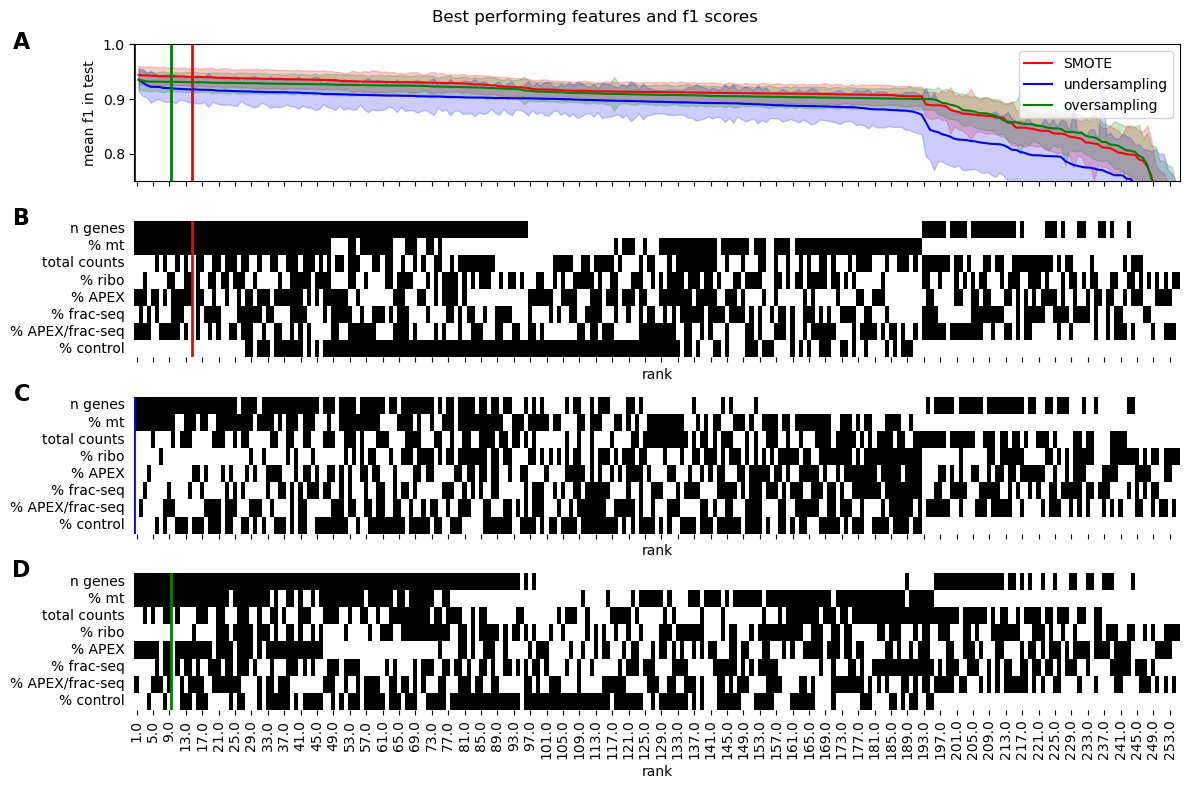

In [71]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(12, 8))
names=["SMOTE","undersampling","oversampling"]
colors=["red","blue","green"]
i=0
for el in ["SMOTE","over","under"]:
    df = pd.read_pickle('outputs/ranks_logistic_strategy_'+el+'_binary.pkl')
    #plotting the results in a nice visualization
    fig.suptitle('Best performing features and f1 scores')
    sns.lineplot(data=df, x=df.index.values, y='mean_f1_test', ax=axes[0],label=names[i],color=colors[i])
    sns.heatmap(df.iloc[:, 29:37].T, cbar=False, cmap=cm.binary, ax=axes[i+1])
    fig.subplots_adjust(hspace=0.0)
    o = list(df.code.values).index(['n_genes', 'pct_counts_mt'])
    print('mean f1 test 1st rank features: ', df.loc[1,'mean_f1_test'])
    print('mean f1 test traditional features', df.loc[o+1,'mean_f1_test'])
    axes[0].set_xlim(0, max(df['rank']))
    axes[0].set_ylim(0.75, 1)
    #min(df_SMOTE_total_corrected_simple['mean_f1_test'])
    #max(df_SMOTE_total_corrected_simple['mean_f1_test'])
    axes[0].set_ylabel('mean f1 in test')
    axes[0].axvline(o, linewidth=2, color=colors[i])
    axes[0].fill_between([i for i in range(1,df.shape[0]+1)],
                    df['std_f1_test'] + df['mean_f1_test'],
                    df['mean_f1_test'] - df['std_f1_test'],
                    facecolor="blue", # The fill color
                    color=colors[i],       # The outline color
                    alpha=0.2)
    axes[i+1].set_yticklabels(['n genes', '% mt', 'total counts','% ribo', '% APEX', '% frac-seq', '% APEX/frac-seq', '% control'])
    axes[i+1].set_ylabel('')
    axes[i+1].tick_params(left=False)
    axes[i+1].axvline(o, linewidth=2, color=colors[i])
    plt.tight_layout()
    #fig.subplots_adjust(hspace=0.5)
    i=i+1
#
labels = ['A', 'B', 'C', 'D']
#
for idx, ax in enumerate(axes):
    ax.text(-0.1, 1.1, labels[idx], transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='right')
fig.savefig('./figures/best_performing_features_macro.png')